In [3]:
%load_ext autoreload
%autoreload 2

import glob
import torch
device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
from importlib import reload  # Not needed in Python 2
import logging
reload(logging)
logging.basicConfig(level=logging.INFO,#控制台打印的日志级别
                    filename='logging.txt',
                    filemode='a',##模式，有w和a，w就是写模式，每次都会重新写日志，覆盖之前的日志
                    #a是追加模式，默认如果不写的话，就是追加模式
                    format=
                    '%(asctime)s : %(message)s',
                    )

# logging.info('\n\n\n\n\n')
# logging.info('with 3 conv grid to concat\n')
# logging.info('2res block, use simple feature: EM inventory simple,2d ALL,3d ALL\n')

import numpy as np
from torchvision.models import ResNet
from torch.utils.data import DataLoader,Dataset
from torch import nn

from dataset.ASdataset import AS_Data
from dataset.ASdataset_obs_train_input import AS_Data_obs
from model import res8,UNet

# test_model = UNet(6+34+16,48)
# test_model.load_state_dict(torch.load('model_save/38_epoch.t'))

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline


In [4]:
# test_model = res8(51+34,27,inplanes=64,layers = [2],T=24) #+5*16
# name = 'res_2layer_correctdata'
# test_model.load_state_dict(torch.load('model_save/res_2layer_9_epoch.t'))
test_model = UNet(51+34,27,T=1,bilinear=False) #+80
name = 'unet2_1month'

test_model.to(device)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(test_model.parameters(),lr=1e-3)


In [5]:
# cfg = {'EM':'/AS_data/Emis_npy/EM_2015_*',
#       'label':'/AS_data/Conc_npy/O3_2015_*',
#       'grid':'/AS_data/Grid_npy/grid_27_182_232.npy',
#       'METCRO2D':'/AS_data/METCRO2D_npy/METCRO2D_2015_*',
#       'METCRO3D':'',
#       'METCRO3D_5height':''}
cfg = {'EM':'/AS_data/Emis_npy/EM_2015_01*',
        'label':'/AS_data/Conc_npy/O3_2015_01*',
        'grid':'/AS_data/Grid_npy/grid_27_182_232.npy',
        'METCRO2D':'/AS_data/METCRO2D_npy/METCRO2D_2015_01*',
        'METCRO3D':'',
        'METCRO3D_5height':''}

print('train data is loading ')
Data = AS_Data(cfg,left = 0,right = 0.75,window = 6)
trainloader = DataLoader(Data,batch_size=8,shuffle=True)
print(len(Data))

print('test data is loading ')
test_Data = AS_Data(cfg,left = 0.7,right = 1,window = 6)
testloader = DataLoader(test_Data,batch_size=8,shuffle=True)
print(len(test_Data))

train data is loading 
/AS_data/Conc_npy/O3_2015_01_744_182_232.npy   is loading
/AS_data/Emis_npy/EM_2015_01_744_51_182_232.npy   is loading
/AS_data/METCRO2D_npy/METCRO2D_2015_01_744_34_182_232.npy   is loading
552
test data is loading 
/AS_data/Conc_npy/O3_2015_01_744_182_232.npy   is loading
/AS_data/Emis_npy/EM_2015_01_744_51_182_232.npy   is loading
/AS_data/METCRO2D_npy/METCRO2D_2015_01_744_34_182_232.npy   is loading
218


In [4]:
def score(model,loader,criterion= nn.L1Loss() ):
    model.eval()
    ls = []
    for idx,i in enumerate(loader):
        with torch.no_grad():
            input,grid,yt_1,label = i
            yt_1 = torch.unsqueeze(yt_1,1)
            input,grid,yt_1,label = input.to(device),grid.to(device),yt_1.to(device),label.to(device)
            y_pred = test_model(input,grid,yt_1)
            
            y_pred = test_model(input,grid,yt_1)

            y_pred = torch.squeeze(y_pred) #,dim = 2)

            y_pred = y_pred.view(label.shape)
            loss = criterion(y_pred,label)
            ls.append(loss.cpu().data)
        
    return np.mean(np.array(ls))

In [ ]:
for epoch in range(66):
    logging.info('-----------{}-----------'.format(epoch))
    ls = []
    
    test_model.train()
    for idx,i in enumerate(trainloader):
        input,grid,yt_1,label = i
        yt_1 = torch.unsqueeze(yt_1,1)
        input,grid,yt_1,label = input.to(device),grid.to(device),yt_1.to(device),label.to(device)
        y_pred = test_model(input,grid,yt_1)

        y_pred = torch.squeeze(y_pred) #,dim = 2)
        optimizer.zero_grad()
        
        y_pred = y_pred.view(label.shape)
        loss = criterion(y_pred,label)
        loss.backward()
        optimizer.step()
        ls.append(loss.cpu().data)
        if len(ls)%400==0:
            logging.info('epoch {} cur loss {}'.format(epoch,np.mean(ls)))
    
    logging.info('epoch {} cur loss {}'.format(epoch,np.mean(ls)))
    test_score_L1 = score(test_model,testloader,criterion = nn.L1Loss()) 
    logging.info('-------------cur test loss L1:  {}'.format(test_score_L1))
    
    if epoch%5 == 0:
        torch.save(test_model.cpu().state_dict(),'model_save/{}_{}_epoch.t'.format(name,epoch))
        test_model.to(device)

In [1]:
import torch


In [2]:
?torch.squeeze

Docstring:
squeeze(input, dim=None, out=None) -> Tensor

Returns a tensor with all the dimensions of :attr:`input` of size `1` removed.

For example, if `input` is of shape:
:math:`(A \times 1 \times B \times C \times 1 \times D)` then the `out` tensor
will be of shape: :math:`(A \times B \times C \times D)`.

When :attr:`dim` is given, a squeeze operation is done only in the given
dimension. If `input` is of shape: :math:`(A \times 1 \times B)`,
``squeeze(input, 0)`` leaves the tensor unchanged, but ``squeeze(input, 1)``
will squeeze the tensor to the shape :math:`(A \times B)`.

.. note:: The returned tensor shares the storage with the input tensor,
          so changing the contents of one will change the contents of the other.

Args:
    input (Tensor): the input tensor
    dim (int, optional): if given, the input will be squeezed only in
           this dimension
    out (Tensor, optional): the output tensor

Example::

    >>> x = torch.zeros(2, 1, 2, 1, 2)
    >>> x.size()
    t

In [4]:
test_model.load_state_dict(torch.load('model_save/best_unet2_1month_60_epoch.t'))

# test_model = res8(51+34+16,27,[3],T=48)

test_model = test_model.to(device)

In [6]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

def image_show(im,title = '',r=10,base=80):
    im[:r,:r] = base
    im[r,r] = 0
    im[im>base] = base
    plt.title(title)
    plt.imshow(im[::-1])
    plt.show()
    

In [27]:
test_model.train()
for idx,i in enumerate(testloader):
    input,grid,yt_1,label = i
    input = torch.squeeze(input,1)
    yt_1 = torch.unsqueeze(yt_1,1)
    input,grid,yt_1,label = input.to(device),grid.to(device),yt_1.to(device),label.to(device)
    input = nn.Parameter(input)
    y_pred = test_model(input,grid,yt_1)
    y_pred = y_pred.view(label.shape)
    loss = criterion(y_pred,label)
    loss.backward()
    break

In [33]:
input.shape

torch.Size([2, 6, 85, 182, 232])

In [ ]:
test_model.state_dict()['']

In [59]:
test_model.bn0.weight

Parameter containing:
tensor([0.4273, 1.0000, 0.4354, 0.3640, 0.8987, 0.3744, 0.7169, 0.8132, 0.3184,
        0.4453, 0.2675, 0.3547, 0.4287, 0.3124, 0.3219, 0.2805, 0.4943, 0.3162,
        0.4453, 0.3690, 0.3655, 0.1774, 0.2707, 0.3132, 0.3653, 0.4136, 0.2344,
        0.3467, 0.2828, 0.3717, 0.3481, 0.4658, 0.7863, 0.5877, 0.1281, 0.2902,
        0.3276, 0.2398, 0.5539, 0.3112, 1.0000, 1.0000, 0.5364, 0.3653, 0.3523,
        0.5439, 0.4545, 0.4493, 0.4548, 1.0000, 0.3367, 1.0421, 1.2415, 1.2832,
        1.8317, 0.5807, 0.9512, 1.1220, 1.1061, 1.1597, 1.1473, 0.6643, 0.9935,
        1.3765, 1.2477, 1.7862, 1.0613, 1.2419, 1.0320, 0.8435, 1.2792, 0.6934,
        0.4266, 0.2924, 0.4538, 0.7678, 0.7436, 0.9385, 1.3578, 2.6443, 1.0199,
        0.9057, 0.7730, 0.8829, 0.5984], device='cuda:0', requires_grad=True)

In [28]:
grad = input.grad

In [29]:
z = np.sum(np.abs(grad[0,:,:,:,:].cpu().numpy()),axis = (2,3))

In [36]:
np.nonzero(z[0]>1)

(array([ 1,  4, 28, 31, 32, 35, 40, 41, 42, 49, 52, 59, 60, 63, 69, 70, 78,
        79]),)

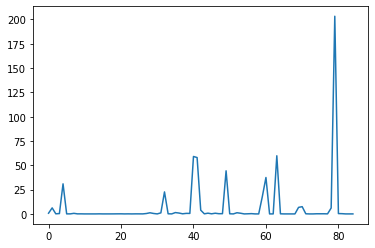

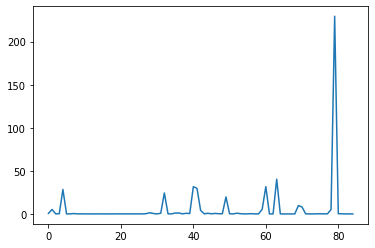

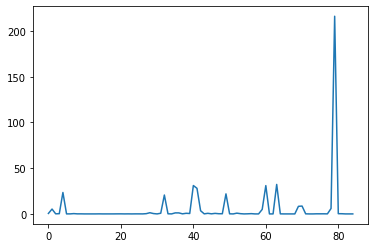

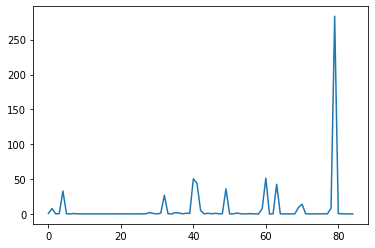

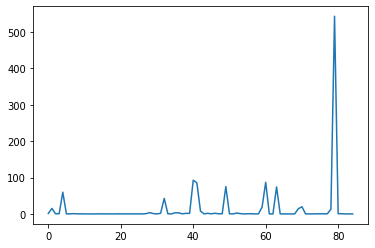

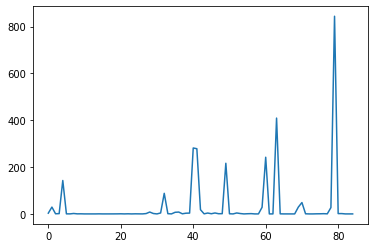

In [31]:
for i in range(6):
    plt.plot(z[i])
    plt.show()

In [26]:
label.shape

torch.Size([8, 182, 232])

In [22]:
optimizer.

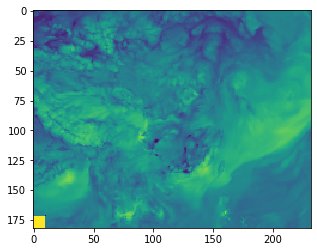

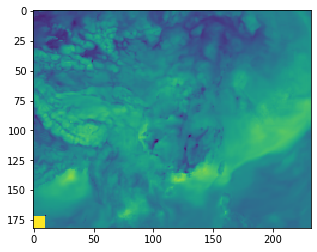

23279


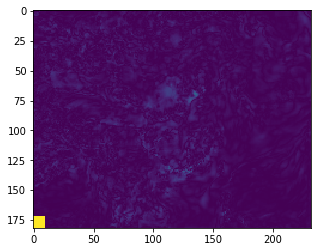

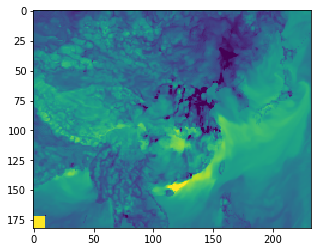

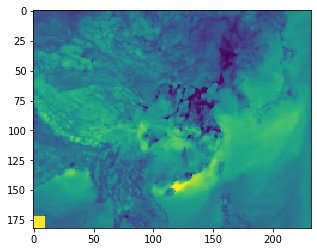

22609


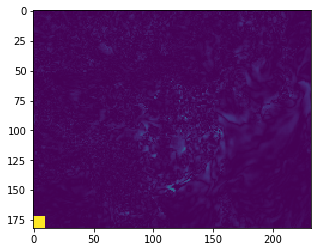

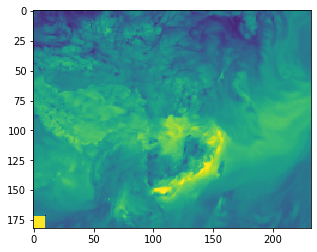

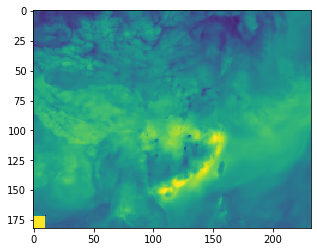

24526


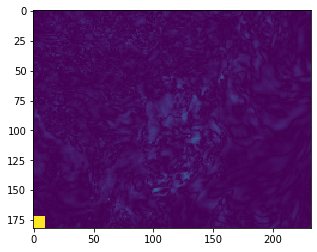

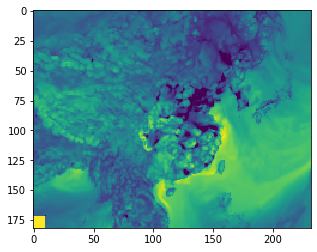

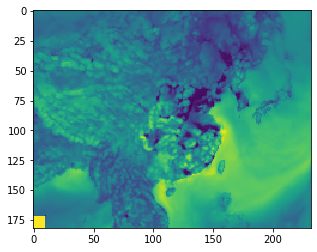

23391


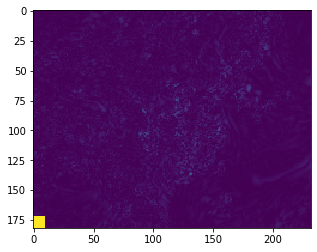

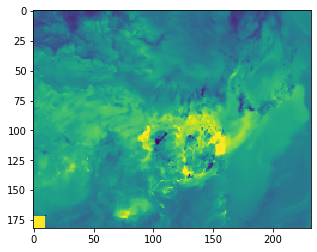

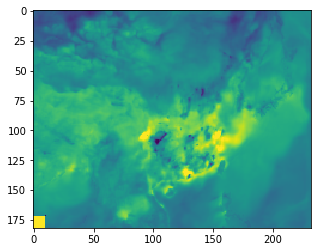

25778


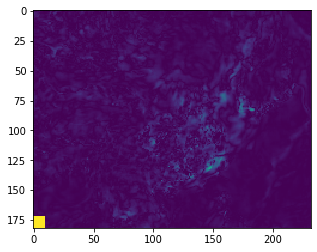

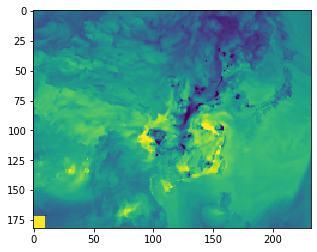

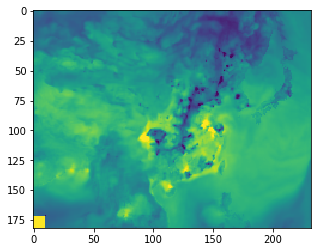

24477


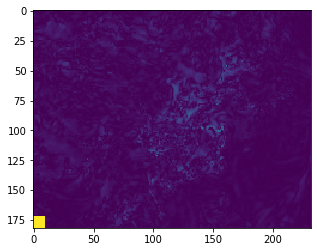

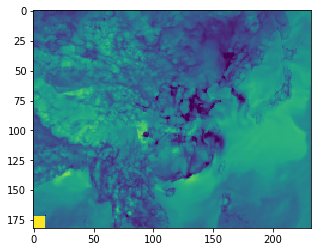

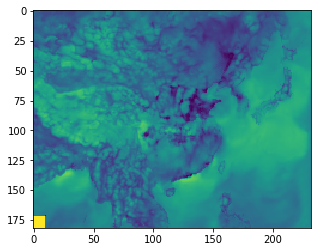

22696


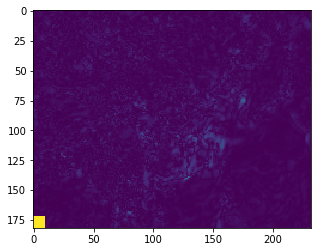

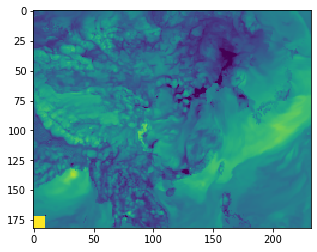

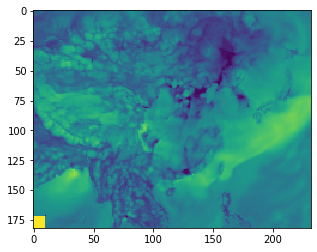

22433


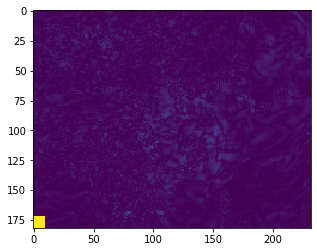

In [7]:
test_model.eval()
for idx,i in enumerate(testloader):
    with torch.no_grad():
        input,grid,yt_1,label = i
        input = torch.squeeze(input,1)
        yt_1 = torch.unsqueeze(yt_1,1)
        input,grid,yt_1,label = input.to(device),grid.to(device),yt_1.to(device),label.to(device)
        y_pred = test_model(input,grid,yt_1)
        
        y_pred = y_pred.squeeze(dim = 1)
        label = label.cpu().numpy()
        y_pred = y_pred.cpu().numpy()
        for b_idx in range(len(label)):
            image1 = label[b_idx]
            image_show(image1)

            image2 = y_pred[b_idx]
            image_show(image2)
            print(np.sum(y_pred[b_idx]>=label[b_idx]))

            image3 = np.abs(image2-image1)
            image_show(image3)
        
        break


In [8]:
import torch
a = torch.randn(4,4)


In [20]:
import numpy as np
labels = np.load('/AS_data/Conc_npy/O3_2015_01_744_182_232.npy')
for i in range(48):
    print(i,np.mean(np.abs(labels[i:]-labels[:744-i])))

0 0.0
1 1.2618659
2 2.4312294
3 3.4814103
4 4.410709
5 5.223562
6 5.925452
7 6.519802
8 7.0082893
9 7.3945417
10 7.684277
11 7.8876786
12 8.013739
13 8.067311
14 8.049162
15 7.957137
16 7.789321
17 7.548805
18 7.243804
19 6.887095
20 6.494405
21 6.086113
22 5.692797
23 5.371518
24 5.2505207
25 5.4928536
26 5.9270167
27 6.42115
28 6.920641
29 7.397266
30 7.83409
31 8.218925
32 8.541506
33 8.795923
34 8.981527
35 9.103271
36 9.166313
37 9.172544
38 9.120054
39 9.0044565
40 8.821548
41 8.573123
42 8.266353
43 7.9131913
44 7.5280457
45 7.130221
46 6.749429
47 6.4376616


torch.Size([2, 4, 4])